In [11]:
import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder

In [12]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [13]:
root_path = "./crop_dataset"

In [14]:
image_size = (512, 1024)

train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(image_size),
    transforms.ToTensor(), 
])

valid_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(image_size),
    transforms.ToTensor(), 
])

In [15]:
batch_size = 1

train_dataset = ImageFolder(root=f'./{root_path}/train', transform=train_transforms) 
valid_dataset = ImageFolder(root=f'./{root_path}/test', transform=valid_transforms) 

train_total = len(train_dataset)
valid_total = len(valid_dataset)

In [16]:
weights = make_weights_for_balanced_classes(train_dataset.imgs, len(train_dataset.classes))                                                              
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, sampler=sampler, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

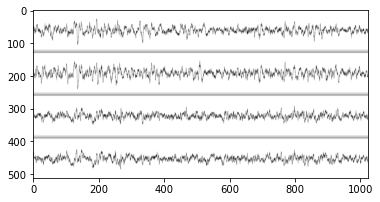

TypeError: Invalid shape (1, 128, 1024) for image data

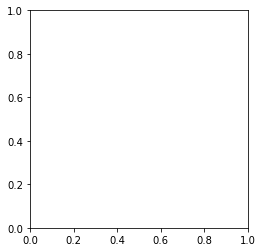

In [20]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

plt.imshow(np.asarray(images[0][0]), cmap=cm.gray)
plt.show()
    
images = images.reshape(-1, 1, 128, 1024)

# plt.imshow(np.asarray(images[0][:,0,:]), cmap=cm.gray)

for image in images[0]:
    plt.imshow(np.asarray(image), cmap=cm.gray)
    plt.show()

print(images[0][0].shape)

In [12]:
import torch.nn as nn
import math


__all__ = ['resnet']

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, depth=32, num_classes=5, block_name='BasicBlock'):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        if block_name.lower() == 'basicblock':
            assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2, e.g. 20, 32, 44, 56, 110, 1202'
            n = (depth - 2) // 6
            block = BasicBlock
        elif block_name.lower() == 'bottleneck':
            assert (depth - 2) % 9 == 0, 'When use bottleneck, depth should be 9n+2, e.g. 20, 29, 47, 56, 110, 1199'
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            raise ValueError('block_name shoule be Basicblock or Bottleneck')


        self.inplanes = 16
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet(**kwargs):
    """
    Constructs a ResNet model.
    """
    return ResNet(**kwargs)

In [13]:
import torchvision.models as models
model = resnet(depth=20, num_classes=5, block_name='basicblock').cuda()

In [14]:
inputs = torch.rand(1, 4, 64, 512).cuda()

model(inputs)

tensor([[-0.6802,  0.7182, -0.7551,  0.3365, -0.6074]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [15]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

In [16]:
train_total = len(train_loader)
valid_total = len(valid_loader)

epochs = 30

In [17]:
model.train()

best = 0

train_log = []
valid_log = []

for e in range(epochs):
    train_loss = 0
    train_correct = 0
    valid_loss = 0
    valid_correct = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        images = images.cuda()
        labels = labels.cuda()
        
        images = images.reshape(-1, 4, 64, 512)
        # images = images.reshape(-1, 4, 64, 4, 256).permute(0, 1, 3, 2, 4).reshape(-1, 16, 64, 256)
        # images = images.reshape(-1, 2, 128, 4, 256).permute(0, 1, 3, 2, 4).reshape(-1, 8, 128, 256)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        train_correct += (predicted == labels).sum().item()
        
        loss = criterion(pred, labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
    train_acc = train_correct / (train_total * batch_size)
    train_loss = train_loss / (train_total * batch_size)
    
    print(f"[TRAIN] Epochs : [{epochs} / {e}] Acc : {train_acc} Loss : {train_loss}")
    train_log.append(train_acc)
    
    model.eval()
    
    for images, labels in valid_loader:  
        images = images.cuda()
        labels = labels.cuda()
        
        images = images.reshape(-1, 4, 64, 512)
        # images = images.reshape(-1, 4, 64, 4, 256).permute(0, 1, 3, 2, 4).reshape(-1, 16, 64, 256)
        # images = images.reshape(-1, 2, 128, 4, 256).permute(0, 1, 3, 2, 4).reshape(-1, 8, 128, 256)
        
        pred = model(images)
        _, predicted = torch.max(pred, 1)
        valid_correct += (predicted == labels).sum().item()
            
    valid_acc = valid_correct / (valid_total * batch_size)
            
    print(f"[VALID] Epochs : [{epochs} / {e}] Acc : {valid_acc}")
    valid_log.append(valid_acc)
    
    if best < valid_acc:
        torch.save(model.state_dict(), './model.pth')
        best = valid_acc

[TRAIN] Epochs : [30 / 0] Acc : 0.5024390243902439 Loss : 0.31282557700949953
[VALID] Epochs : [30 / 0] Acc : 0.3693181818181818
[TRAIN] Epochs : [30 / 1] Acc : 0.2056910569105691 Loss : 0.41897406563526246
[VALID] Epochs : [30 / 1] Acc : 0.23200757575757575
[TRAIN] Epochs : [30 / 2] Acc : 0.2048780487804878 Loss : 0.40245616634686787
[VALID] Epochs : [30 / 2] Acc : 0.23200757575757575
[TRAIN] Epochs : [30 / 3] Acc : 0.1991869918699187 Loss : 0.40240862316232384
[VALID] Epochs : [30 / 3] Acc : 0.07859848484848485
[TRAIN] Epochs : [30 / 4] Acc : 0.21951219512195122 Loss : 0.40236765601770663
[VALID] Epochs : [30 / 4] Acc : 0.14867424242424243
[TRAIN] Epochs : [30 / 5] Acc : 0.19552845528455284 Loss : 0.4053117720092215
[VALID] Epochs : [30 / 5] Acc : 0.1278409090909091
[TRAIN] Epochs : [30 / 6] Acc : 0.2 Loss : 0.4024664093323839
[VALID] Epochs : [30 / 6] Acc : 0.14867424242424243
[TRAIN] Epochs : [30 / 7] Acc : 0.20203252032520325 Loss : 0.4024314340052566
[VALID] Epochs : [30 / 7] Acc

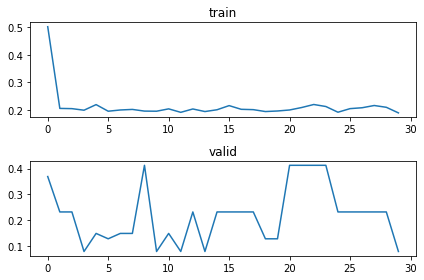

In [18]:
fig, ax = plt.subplots(2, 1)

ax[0].set_title("train")
ax[0].plot(train_log)
ax[1].set_title("valid")
ax[1].plot(valid_log)

fig.tight_layout()
plt.show()

In [19]:
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [21]:
model.eval()
 
valid_correct = 0   

for images, labels in valid_loader:  
    images = images.cuda()
    labels = labels.cuda()

    images = images.reshape(-1, 4, 64, 512)
    # images = images.reshape(-1, 256, 4, 256).permute(0, 2, 1, 3)
    # images = images.reshape(-1, 2, 128, 4, 256).permute(0, 1, 3, 2, 4).reshape(-1, 8, 128, 256)
    
    pred = model(images)
    
    _, predicted = torch.max(pred, 1)
    valid_correct += (predicted == labels).sum().item()

valid_acc = valid_correct / (valid_total * batch_size)

print(f"[VALID] Acc : {valid_acc}")

[VALID] Acc : 0.4128787878787879
